In [47]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

In [48]:
seed = 123
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# change to the actual path
images_path = "E:\\IOAI\\kits\\nitro-nlp-25"

# Data preparation

In [49]:
class DuckDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.root_dir = root_dir
        self.df = self.prep_df(csv_file)
        self.target_size = (224, 224)

        self.jitter = transforms.ColorJitter(
            brightness=0.5, contrast=0.5, saturation=0.5
        )

    def get_ratio(self):
        return self.df["Ratio"].mean()

    def prep_df(self, csv_file):
        df = pd.read_csv(csv_file)

        # convert string of number to a proper list
        df["BoundingBox"] = (
            df["BoundingBox"].str.split().apply(lambda x: list(map(float, x)))
        )

        # feature engineering
        df["BoundingBoxArea"] = df["BoundingBox"].apply(lambda b: (b[2] - b[0]) * (b[3] - b[1])) 
        df["Ratio"] = df["PixelCount"] / df["BoundingBoxArea"]
        # and now pixel_count = df["Ratio"] * df["BoundingBoxArea"]

        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row.iloc[0]
        img_path = os.path.join(self.root_dir, f"{filename}.png")
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # 1. original bbox
        x1, y1, x2, y2 = row["BoundingBox"]

        # 2. resize image and scale bbox
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        scale_x = self.target_size[0] / orig_w
        scale_y = self.target_size[1] / orig_h
        x1, x2 = x1 * scale_x, x2 * scale_x
        y1, y2 = y1 * scale_y, y2 * scale_y
        bbox = [x1, y1, x2, y2]

        # 3. random horizontal flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [W - x2, y1, W - x1, y2]

        # 4. random vertical flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [x1, H - y2, x2, H - y1]

        # 5. augmentations that don't affect the bbox
        image = self.jitter(image)
        image = transforms.ToTensor()(image)

        # 6. repare labels
        has_duck = torch.tensor([row["DuckOrNoDuck"]], dtype=torch.float32)
        pixel_count = torch.tensor([row["PixelCount"]], dtype=torch.float32)
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        labels = torch.cat((has_duck, pixel_count, bbox_tensor))
        return image, labels

In [50]:
_train_dataset = DuckDataset(
    csv_file='train_data.csv',
    root_dir=f'{images_path}\\train_dataset'
)

In [51]:
total_size = len(_train_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(
    _train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# EDA

tensor([1.0000e+00, 4.2510e+03, 1.0260e+01, 1.1001e+02, 7.8656e+01, 1.9208e+02])


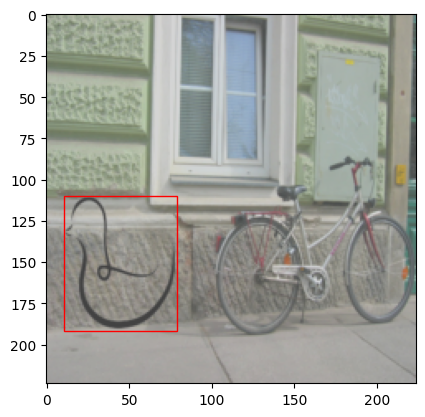

In [52]:
import matplotlib.patches as patches

sample, labels = next(iter(train_dataset))
sample = sample.permute(1, 2, 0)
print(labels)
fig, ax = plt.subplots()

ax.imshow(sample)

rect = patches.Rectangle(
    (labels[2], labels[3]),
    labels[4] - labels[2],
    labels[5] - labels[3],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

# Model selection - is there a duck?

In [53]:
class DuckNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.detect_duck = nn.Linear(128, 1)

    def forward(self, images):
        # 1. extract image features
        feats = self.backbone(images)

        # 2. is there a duck?
        is_duck = self.detect_duck(feats)

        return is_duck

model = DuckNet().to(device)

In [54]:
# sanity check
sample, labels = next(iter(train_dataset))
sample = sample.unsqueeze(0) # batch dim
model(sample.to(device))

tensor([[0.0395]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [55]:
def get_loss(outputs, targets):
    loss_duckornoduck  = F.binary_cross_entropy_with_logits(outputs[:, 0], targets[:, 0])

    loss = loss_duckornoduck
    return loss


optimizer = optim.AdamW(model.parameters(), lr=1e-5)

In [56]:
loss_values = []

In [57]:
%%script true
# avoid executation, load pretrained

num_epochs = 5
for epoch in range(num_epochs):
    # training
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in pbar:
        images, targets = images.to(device), labels.to(device)

        # forward pass
        optimizer.zero_grad()
        outputs = model(images)

        loss = get_loss(outputs, targets)

        # backward pass
        loss.backward()
        optimizer.step()

        # stats for nerds
        loss_values.append(loss.item())
        train_loss += loss.item() * images.size(0)
    train_loss /= train_size

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_epochs}"):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = get_loss(outputs, targets)

            val_loss += loss.item() * images.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Couldn't find program: 'true'


In [58]:
plt.figure(figsize=(13, 6))
# plt.plot(loss_values)

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

In [59]:
torch.save(model.state_dict(), "duck_detector.pth")

# Model selection - bounding box

In [60]:
%%script true
# avoid executation, load pretrained

# 1) Prepare a detection dataset
class DuckDetectDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_size=(224, 224)):
        self.df = pd.read_csv(csv_file)
        self.df["BoundingBox"] = (
            self.df["BoundingBox"].str.split().apply(lambda x: list(map(float, x)))
        )
        self.root = root_dir
        self.resize = transforms.Resize(target_size)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.root, f"{row.DatapointID}.png")).convert(
            "RGB"
        )
        orig_w, orig_h = img.size
        img = self.resize(img)
        scale_x = img.width / orig_w
        scale_y = img.height / orig_h

        if row.DuckOrNoDuck == 1:
            x1, y1, x2, y2 = row.BoundingBox
            box = torch.tensor(
                [[x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y]],
                dtype=torch.float32,
            )
            label = torch.tensor([1], dtype=torch.int64)
        else:
            box = torch.zeros((0, 4), dtype=torch.float32)
            label = torch.zeros((0,), dtype=torch.int64)

        target = {"boxes": box, "labels": label}
        return self.to_tensor(img), target


# 2) Instantiate and fine-tune Faster R-CNN
detector = fasterrcnn_mobilenet_v3_large_fpn(
    weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT,
    trainable_backbone_layers=3,
).to(device)

# swap in a 2-class head (background + duck)
in_feat = detector.roi_heads.box_predictor.cls_score.in_features
detector.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes=2)

detector = detector.to(device)

# loader
det_ds = DuckDetectDataset("train_data.csv", f"{images_path}\\train_dataset")
det_loader = DataLoader(
    det_ds, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

# optimizer + train loop
detector.train()
opt_det = optim.AdamW(detector.parameters(), lr=1e-4)
for epoch in range(3):
    epoch_loss = 0
    for imgs, targets in det_loader:
        imgs = [img.to(device) for img in imgs]
        tgts = []
        for t in targets:
            tgts.append({
                "boxes": t["boxes"].to(device),
                "labels": t["labels"].to(device),
            })        
        
        losses = detector(imgs, tgts)
        loss = sum(loss for loss in losses.values())

        opt_det.zero_grad()
        loss.backward()
        opt_det.step()
        epoch_loss += loss.item()
    print(f"Det-epoch {epoch+1} loss: {epoch_loss/len(det_loader):.4f}")

detector.eval()
torch.save(detector.state_dict(), "bounding_box.pth")

Couldn't find program: 'true'


# Submission

In [61]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.lower().endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.root_dir, fname)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        base = os.path.splitext(fname)[0]
        return image, base


test_dataset = TestDataset(
    root_dir=f"{images_path}\\test_dataset",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [62]:
model.load_state_dict(torch.load("duck_detector.pth"))
model.eval()

detector = fasterrcnn_mobilenet_v3_large_fpn(
    weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT,
    trainable_backbone_layers=3,
)

detector.roi_heads.box_predictor = FastRCNNPredictor(
    detector.roi_heads.box_predictor.cls_score.in_features, num_classes=2
)

detector = detector.to(device)
detector.load_state_dict(torch.load("bounding_box.pth"))
detector.eval()

subtask1, subtask2, subtask3 = [], [], []
ratio = _train_dataset.get_ratio()

with torch.no_grad():
    for images, bases in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        # 1) classification head
        logits = model(images).squeeze(1)
        # 2) detection head
        det_outputs = detector(images)

        for base, logit, det in zip(bases, logits, det_outputs):
            has_duck = int(torch.sigmoid(logit) >= 0.5)
            subtask1.append((1, base, has_duck))

            if has_duck:
                # take top-scoring box >= 0.5
                if len(det["boxes"]) and det["scores"][0] >= 0.5:
                    x1, y1, x2, y2 = det["boxes"][0].cpu().int().tolist()
                else:
                    x1 = y1 = x2 = y2 = 0
                subtask3.append((3, base, f"{x1} {y1} {x2} {y2}"))
                area = max(0, (x2 - x1) * (y2 - y1))
                subtask2.append((2, base, int(ratio * area)))
            else:
                subtask3.append((3, base, "0 0 0 0"))
                subtask2.append((2, base, 0))

Testing: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


In [66]:
subtask1 = pd.DataFrame(subtask1, columns=["subtaskID", "datapointID", "answer"])
subtask2 = pd.DataFrame(subtask2, columns=["subtaskID", "datapointID", "answer"])
subtask3 = pd.DataFrame(subtask3, columns=["subtaskID", "datapointID", "answer"])

In [67]:
submission = pd.concat([subtask1, subtask2, subtask3], ignore_index=True)

submission.head()

,subtaskID,datapointID,answer
0,1,1,1
1,1,10,1
2,1,100,1
3,1,101,1
4,1,102,1


In [68]:
submission.to_csv("submission.csv", index=False)